In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
from scipy.ndimage import gaussian_filter1d
from math import floor
import leidenalg as la
import igraph as ig
from elephant.spike_train_generation import homogeneous_poisson_process
import elephant.conversion as conv
import neo as n
import quantities as pq
from quantities import Hz, s, ms

In [2]:
class temporal_network:#object for creating node-aligned(every node exists every layer)
                       #with diagonal coupling(inter-layer edges exist only between node to itself)
        
    ##################################
    # TODO: extend omega(scalar) for vector and matrix
    ##################################
        
    def __init__(self, size, length, window_size, data, **kwargs):
        
        if length < 1: raise ValueError('Object should be a multilayer network with at least 2 layers')
        if size < 3: raise ValueError('Layers must have at least 3 nodes')
        
        self.size = size # number of nodes in every layer
        self.length = length # number of layers
        self.nodes = [i for i in range(self.size)]
        self.windowsize = window_size
        
        #### data: supra__adjacency, list_adjacency, edge_list
        
        ##         if supra__adjacency: creates the list adjacency matrix
        ##
        ##                     --- additional arguments ---
        ##                       - supra_adjacency: supra adjacency matrix of shape (size*time x size*time)
        
        
        ##
        ##         if edge__list: creates directed weighted multilayer network from the egde quadraplets
        ##                      given of the form (i,j,w,t). supra_adjacency and list_adjacency matrices 
        ##                      are automatically created. Caveat: if you use edge_list only firing neurons are going
        ##                      to be taken ito consideration.
        ##
        ##                     --- additional arguments ---
        ##                       - edge_list: list of quadreplets e.g. [(0,2,w1,1),(2,1,w2,1),(0,1,w3,2),(0,2,w4,2)]
        ##                       - omega: interlayer coupling strength, can be a float only for now
        ##                       - kind: if ordinal, only adjacent layers gets connected with strength scalar 'omega'
        ##                               if cardinal, all layers get connected w/ each other w/ strength scalar 'omega'
        
        
        ##         if list__adjacency: creates the supra adjacency matrix from given list of adjacency matrices
        ##                             of monolayer networks
        ##                             TODO:add a warning to check if the adjacency matrices are node-aligned
        ##                      
        ##              
        ##                     --- additional arguments ---
        ##                       - list_adjacency: list of length 'length' that contains individual adjacency
        ##                                         matrices of each layer that are numpy arrays
        ##                       - omega: interlayer coupling strength, can be a float only for now
        ##                       - kind : if ordinal, only adjacent layers gets connected w/ strength scalar'omega'
        ##                                if cardinal, all layers get connected w/ each other w/ strength scalar'omega'
        ##
        ####
                    
        if  data == 'supra__adjacency':
            self.supra_adjacency = kwargs['supra_adjacency']
            list_adjacency = [ [] for i in range(length) ]
            
            for i in range(self.length):
                list_adjacency[i] = self.supra_adjacency[i*self.size:(i+1)*self.size,i*self.size:(i+1)*self.size]
            
            self.list_adjacency = list_adjacency
            
            edge_list = []
            for i in range(self.length):
                A = self.list_adjacency[i]
                firing = np.transpose(np.nonzero(A))
                for j,m in enumerate(firing):
                    quadreplet =(m[0],m[1],A[m[0],m[1]],i)
                    edge_list.append(quadreplet)
            self.edgelist = edge_list
                
        
        elif data == 'edge__list':
            self.edgelist = kwargs['edge_list']
            supra_adjacency = np.zeros((self.size*self.length,self.size*self.length))
            list_adjacency = [ [] for i in range(self.length) ]
            for q in range(self.length):
                list_adjacency[q]=np.zeros((self.size,self.size))
            
            for k,e in enumerate(self.edgelist):
                i,j,w,t = e[0], e[1], e[2],e[3]
                supra_adjacency[self.size*(t)+i][self.size*(t)+j] = w
                list_adjacency[t][i][j] = w

        
            ##filling off-diagonal blocks
            if kwargs['kind'] == 'ordinal':
                for n in range(self.size*(self.length-1)):
                    supra_adjacency[n][n+self.size] = kwargs['omega']
                    supra_adjacency[n+self.size][n] = kwargs['omega']
                
            elif kwargs['kind'] == 'cardinal':
                i = 0
                while self.length-i != 0:
                    i = i+1
                    for n in range(self.size*(self.length-i)):
                        supra_adjacency[n][n+i*self.size] = kwargs['omega']
                        supra_adjacency[n+i*self.size][n] = kwargs['omega']
            
            self.supra_adjacency = supra_adjacency
            self.list_adjacency = list_adjacency
            
        elif data == 'list__adjacency':
            self.list_adjacency = kwargs['list_adjacency']
            supra_adjacency = np.zeros((self.size*self.length,self.size*self.length))
            
            for i in range(self.length):
                supra_adjacency[i*self.size:(i+1)*self.size,i*self.size:(i+1)*self.size] = self.list_adjacency[i]
            
            ##filling off-diagonal blocks
            if kwargs['kind'] == 'ordinal':
                for n in range(self.size*(self.length-1)):
                    supra_adjacency[n][n+self.size] = kwargs['omega']
                    supra_adjacency[n+self.size][n] = kwargs['omega']
                
            elif kwargs['kind'] == 'cardinal':
                i = 0
                while self.length-i != 0:
                    i = i+1
                    for n in range(self.size*(self.length-i)):
                        supra_adjacency[n][n+i*self.size] = kwargs['omega']
                        supra_adjacency[n+i*self.size][n] = kwargs['omega']
            
            self.supra_adjacency = supra_adjacency
            
            edge_list = []
            for i in range(self.length):
                A = self.list_adjacency[i]
                firing = np.transpose(np.nonzero(A))
                for j,m in enumerate(firing):
                    quadreplet =(m[0],m[1],A[m[0],m[1]],i)
                    edge_list.append(quadreplet)
            self.edgelist = edge_list
            
    def aggragate(self, normalized = True):
        t = self.length
        n = self.size
        aggragated = np.zeros((n,n))
        
        for i,c in enumerate(self.list_adjacency):
            aggragated = aggragated + c
            
        if normalized: return (aggragated/t)
        else: return (aggragated)
            
    def modularity_matrix(self, omega, gamma):##TODO: fix modularity matrix
        N = self.size
        T = self.length
        B = np.zeros((N*T,N*T))
        two_mu = 0
        for i in range(T):
            k = np.sum(self.multi_array[i],0)
            two_m = np.sum(k,0)
            two_mu = two_mu + two_m
            B[i*N:(i+1)*N,i*N:(i+1)*N] = self.multi_array[i] - (gamma * k.T*k)/(two_m)
        two_mu = two_mu + 2*omega*N*(T-1)
        
        for p in range(N*(T-1)):
            B[p][p+N] = omega 
            B[p+N][p] = omega
            
        return(B)
    
    def binarize(self, array):
        n,t = array.shape
        binary_spikes = np.zeros(array.shape)
        for i in range(n):
            for j in range(t):
                if array[i][j] == 0: pass
                else: binary_spikes[i][j] = 1
        return(binary_spikes)
    
    def bin_time_series(self, array, gaussian = True, **kwargs):
        #input: nxt matrix 
        #returns: binned time series i.e. l x n x binsize
        binsize = self.windowsize
        n = array.shape[0] # number of neurons
        totalsize = array.shape[1] # total duration of spikes
        l = int(totalsize/binsize) # number of resulting layers
        if gaussian:
            for i in range(n):
                array[i] = gaussian_filter(array[i],kwargs['sigma'])
    
        A = np.zeros((l,n,binsize))
        for i in range(l):
            A[i] = array[:,i*binsize:(i+1)*binsize]
        return(A)
    
    def edgelist2edges(self):# helper to create igraphs
        T = self.length
        all_edges = [[] for i in range(T)]
        all_weights = [[] for i in range(T)]
        dtype = [('row',int),('column',int),('weight',float),('layer',int)]
        for k,e in enumerate(np.sort(np.array(self.edgelist, dtype=dtype),order='layer')):
            i,j,w,t = e[0], e[1], e[2],e[3]
            pair = (i,j)
            all_edges[t].append(pair)
            all_weights[t].append(w)
        return (all_edges, all_weights)
    
    def neighbors(self, node_id, layer):
        
        if node_id > self.size: return('Invalid node ID')
        if layer > self.length: return('Invalid layer')
        neighbors = []
        
        for k,e in enumerate(self.edgelist):
            i,j,w,t = e[0],e[1],e[2],e[3]
            if t != layer:pass
            else:
                if i != node_id:pass
                else:neighbors.append(j)
                    
        return(neighbors)
    
    def average_degree(self,layer):
        
        average_degree = 0
        
        for i in range(self.size):
            average_degree = average_degree + len(self.neighbors(i,layer))
        
        return(average_degree/(2*self.size))
    
    def create_igraph(self):
        T = self.length
        N = self.size
        G = []
        edges = self.edgelist2edges()[0]
        weights = self.edgelist2edges()[1]
        for i in range(T):
            G.append(ig.Graph())
            G[i].add_vertices(N)
            G[i].add_edges(edges[i])
            G[i].es['weight'] = weights[i]
            G[i].vs['id'] = list(range(N))
            G[i].vs['node_size'] = 0
        return(G)

    
    def leiden(self, G, interslice, resolution):
        
        layers, interslice_layer, G_full = la.time_slices_to_layers(G, interslice_weight = interslice)
        
        partitions = [la.RBConfigurationVertexPartition(H, 
                                            weights = 'weight', 
                                            resolution_parameter = resolution) for H in layers]
        
        interslice_partition = la.RBConfigurationVertexPartition(interslice_layer, 
                                                                 weights = 'weight',
                                                                 resolution_parameter = 0)
                                                     
        optimiser = la.Optimiser()
        
        diff = optimiser.optimise_partition_multiplex(partitions + [interslice_partition])

        return(partitions, interslice_partition)
    
    def membership(self, interslice_partition): ## returns the community assignments from the leiden algorithm as
        ##                                       tuple (n,t) n is the node id t is the layer that node is in
        n = self.size
        membership = [[] for i in range(interslice_partition._len)]
        for i,m in enumerate(interslice_partition._membership):
            time = floor(i/n)
            node_id = i%n
            membership[m].append((node_id,time))
        return(membership, len(membership))
    
    def community(self, membership, ax, pv = None):
        n = self.size
        t = self.length
        number_of_colors = len(membership)


        comms = np.zeros((n,t))

        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]

        for i, l in enumerate(membership):
            for j,k in enumerate(l):
                comms[k[0]][k[1]] = i

        cmap = mpl.colors.ListedColormap(color)

        #fig,ax = plt.subplots(1,1,figsize=(7,5))
        ax.imshow(comms, interpolation = 'none', cmap = cmap, aspect = 'auto', origin = 'lower',extent = [-0.5,t-0.5,-0.5,n-0.5])
        ax.set_xticks(np.arange(t))
        if pv is not None: ax.set_yticks(pv)
        ax.tick_params(axis = 'both', labelsize = 13)
        ax.set_xlabel('Layers (Time)', fontsize = 15)
        ax.set_ylabel('Neuron ID', fontsize = 15)
        ax.set_title('Community Assignments with %d Communities' %len(color), fontsize = 20)
        return(comms, color)
    
    def raster_plot(self, spikes, ax, color = None, **kwargs):#plots the raster plot of the spike activity on a 
        # given axis 'comm_assignment' and 'color' arguments are the outputs of the function 'community' 
        # and they display the community assignment of the spiking activity if provided. if not, raster 
        # ais going to be plotted blue
        binsize = self.windowsize
        binarized_spikes = self.binarize(spikes)
        binned_spikes = self.bin_time_series(binarized_spikes, gaussian = False)
        l,n,t = binned_spikes.shape
                    
        sp = np.nonzero(binned_binary_spikes)
        
        if color is None: 
            col = [0]*l
            clr = [col for i in range(n)]
            color = ['#0000ff']
        else: clr = kwargs['comm_assignment']
        
        cmap = mpl.colors.ListedColormap(color)
        
        for i in range(len(sp[0])):
            ax.scatter(sp[0][i]*binsize+sp[2][i],  sp[1][i], 
                       s = 5, 
                       c = color[int(clr[sp[1][i]][sp[0][i]])], 
                       marker = 'x', 
                       figure = fig, 
                       cmap = cmap)
            
        ax.set_title('Raster Plot', fontsize = 20)
        ax.set_xlabel('Time (Frames)', fontsize = 15)
        ax.set_ylabel('Neuron ID', fontsize = 15)
        ax.set_xticks([t*i for i in range(l+1)])
        ax.set_yticks([5*i for i in range(int(n/5)+1)]+[n])
        ax.tick_params(axis = 'x', labelsize = 10)
        ax.tick_params(axis = 'y', labelsize = 13)

In [3]:
def normalized_cross_corr(x,y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    x_cov_std = np.nanmax(np.sqrt(np.correlate(x - x_mean, x - x_mean, 'full')))
    y_cov_std = np.nanmax(np.sqrt(np.correlate(y - y_mean, y - y_mean, 'full')))

    normalization = x_cov_std * y_cov_std
        

    unnormalized_correlation = np.correlate(x - x_mean, y - y_mean, 'full')
    
    corr_array = unnormalized_correlation/normalization

    return(corr_array)

def max_norm_cross_corr(x1, x2):
    
    correlation= normalized_cross_corr(x1, x2)
    
    lag = abs(correlation).argmax() - len(x1)+1
    
    max_corr = max(abs(correlation))
    
    return(max_corr, lag)

def cross_correlation_matrix(data):
    #input: n x t matrix where n is the number of rois and t is the duration of the time series
    #return: n x n symmetric cross correlation matrix, nxn uppertriangular cross correlation matrix and lag matrix
    n, t = data.shape
    X = np.zeros((n,n))
    lag = np.zeros((n,n))
    
    for i in range(n-1):
        for j in range(i+1,n):
            X[i][j],lag[i][j] = max_norm_cross_corr(data[i,:],data[j,:])
    X[np.isnan(X)] = 0
    lag[np.isnan(lag)] = 0
    
    X_full = X + X.T
    lag = lag + lag.T
    return(X_full, X, lag)

In [4]:
def bin_time_series(array, binsize, gaussian = True, **kwargs):
    #input: nxt matrix 
    #returns: binned time series i.e. l x n x binsize
    
    n = array.shape[0] # number of neurons
    totalsize = array.shape[1] # total duration of spikes
    l = int(totalsize/binsize) # number of resulting layers
    if gaussian:
        for i in range(n):
            array[i] = gaussian_filter(array[i],kwargs['sigma'])
    
    A = np.zeros((l,n,binsize))
    for i in range(l):
        A[i] = array[:,i*binsize:(i+1)*binsize]
    return(A)

def binarize(array):
    n,t = array.shape
    binary_spikes = np.zeros((n,t))
    for i in range(n):
        for j in range(t):
            if array[i][j] == 0: pass
            else: binary_spikes[i][j] = 1
    return(binary_spikes)

def gaussian_filter(array,sigma):
    #sigma=0.25==gaussian kernel with length 3
    #sigma=0.5==gaussian kernel with length 5
    #sigma=1==gaussian kernel with length 9
    return(gaussian_filter1d(array,sigma))

def jitter(spike, k):
    #jittering the given spike train
    jittered = np.zeros(spike.shape)
    for i in np.nonzero(spike)[1]:
        jitt = random.randint(-k,k)
        try:jittered[0,i+jitt] = 1
        except:jittered[0,i] = 1
    return(jittered)

def spike_count(spikes, num_bins, spy = True, t_min = None, t_max = None):
    n,t = spikes.shape
    if t_min is None: t_min = 0
    if t_max is None: t_max = t
    if t_max<=t_min: raise ValueError('t_min should be less than t_max')
    spike_count = []
    for i in range(n):
        spike_count.append(np.sum(spikes[i][t_min:t_max]))
    n, bins, patches = plt.hist(spike_count, num_bins, facecolor='blue', alpha=0.5)
    if spy: plt.show()
    return(n,bins)

In [5]:
spike_rate = [10, 30, 20] # spike rate per merging event. communities merge by changing their firing rate
comm_sizes = [[30,5,20,5,20,10,10],[35,25,40],[100]] # community sizes at every merging event
num_neurons = int(sum(comm_sizes[0]))
bin_size = 1000.0 # in frames, in every bin_size, a community activity occurs
seconds = len(spike_rate)
total_duration = int(seconds*bin_size)
window_size = 1000 # size, in frames, each adjacency matrix correspond to. better to be equal to bin_size 
standard_dev = 1.2 # for gaussian kernel
k = 5 #for jittering the spikes
layers = int(total_duration/window_size)

In [6]:
spikes = np.zeros((num_neurons, total_duration))
for s in range(seconds):
    neuron_count = 0
    for i,e in enumerate(comm_sizes[s]):
        initial_master = homogeneous_poisson_process(rate = spike_rate[s]*Hz, t_start = s*ms, t_stop = (s+1)*bin_size*ms, as_array=True)
        master_spikes = np.zeros((1,total_duration))
    
        for j,f in enumerate(initial_master):
            master_spikes[0][int(f)] = 1

        for j in range(e):
            spikes[neuron_count+j][int(s*bin_size):int((s+1)*bin_size)] = jitter(master_spikes[:,int(s*bin_size):int((s+1)*bin_size)], k)
        neuron_count = neuron_count + e

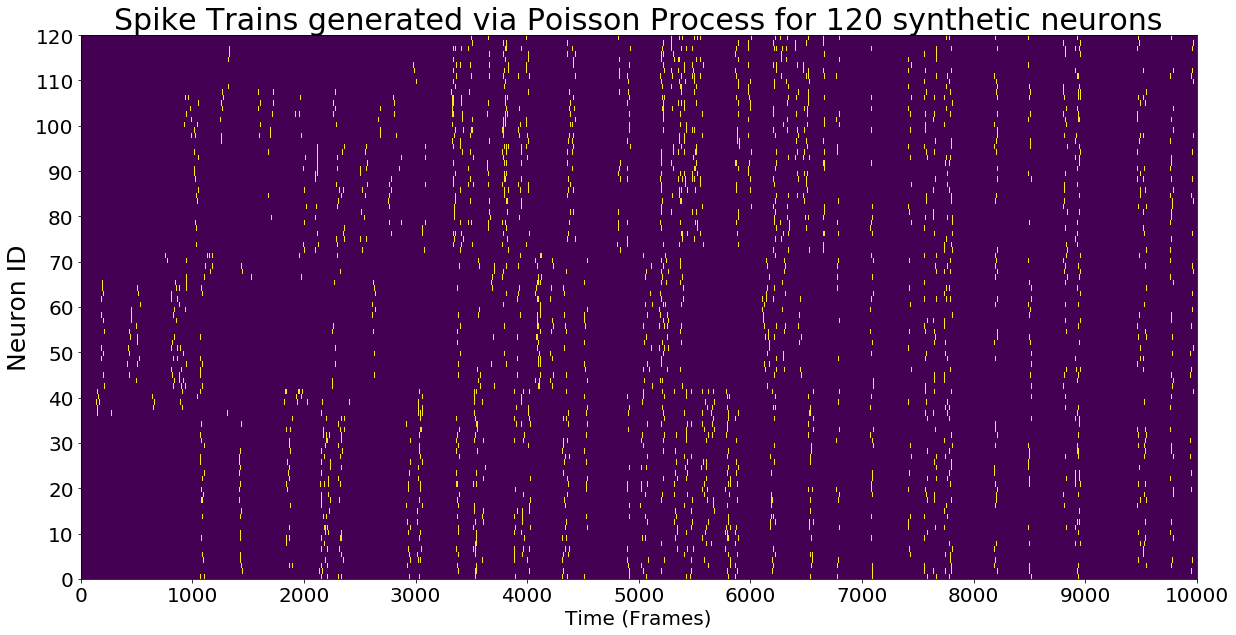

In [7]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.imshow(spikes, origin = 'lower', interpolation='nearest', aspect='auto',  extent = [0,10000,0,120])
ax.set_title('Spike Trains generated via Poisson Process for 120 synthetic neurons', fontsize= 30)
ax.set_xlabel('TIME (in Miliseconds)', fontsize = 20)
ax.set_xticks([j*1000 for j in range(11)])
ax.set_yticks([i*10 for i in range(13)])
ax.set_ylabel('Neuron ID', fontsize = 25)
ax.set_xlabel('Time (Frames)', fontsize = 20)
ax.tick_params(axis = 'both', labelsize = 20)
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/spiketrain_merge.pdf')

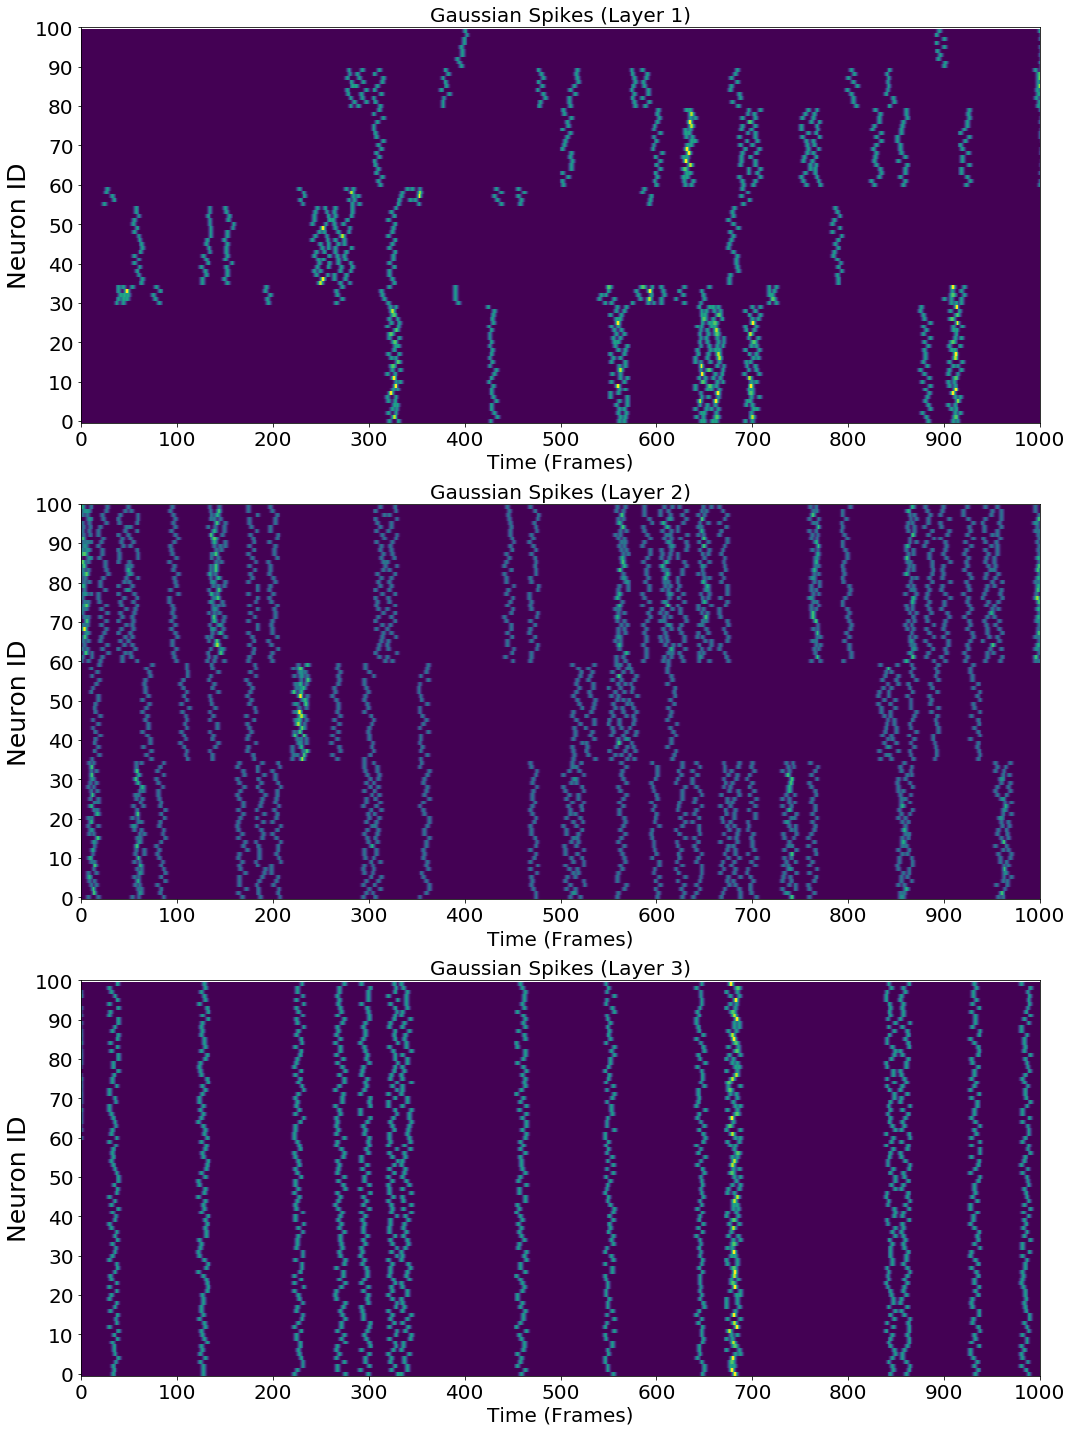

In [9]:
binned_spikes = bin_time_series(spikes, window_size, gaussian = True, sigma = standard_dev)
fig,ax = plt.subplots(layers,1,figsize=(15,20))
for i in range(layers):
    ax[i].imshow(binned_spikes[i], origin = 'lower', interpolation='nearest', aspect='auto')
    ax[i].set_title('Gaussian Spikes (Layer %d)'%(i+1), fontsize = 20)
    ax[i].set_xlabel('TIME (in Miliseconds)', fontsize = 20)
    ax[i].set_xticks([j*100 for j in range(11)])
    ax[i].set_yticks([j*10 for j in range(11)])
    ax[i].set_ylabel('Neuron ID', fontsize = 25)
    ax[i].set_xlabel('Time (Frames)', fontsize = 20)
    ax[i].tick_params(axis = 'both', labelsize = 20)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/binned_spiketrain_merge.pdf')

In [10]:
##create cross-correlation matrices that are the adjacency matrices of the network at each layer
adjacency_matrices = []
for i in range(layers):
    adjacency_matrices.append(cross_correlation_matrix(binned_spikes[i])[0])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


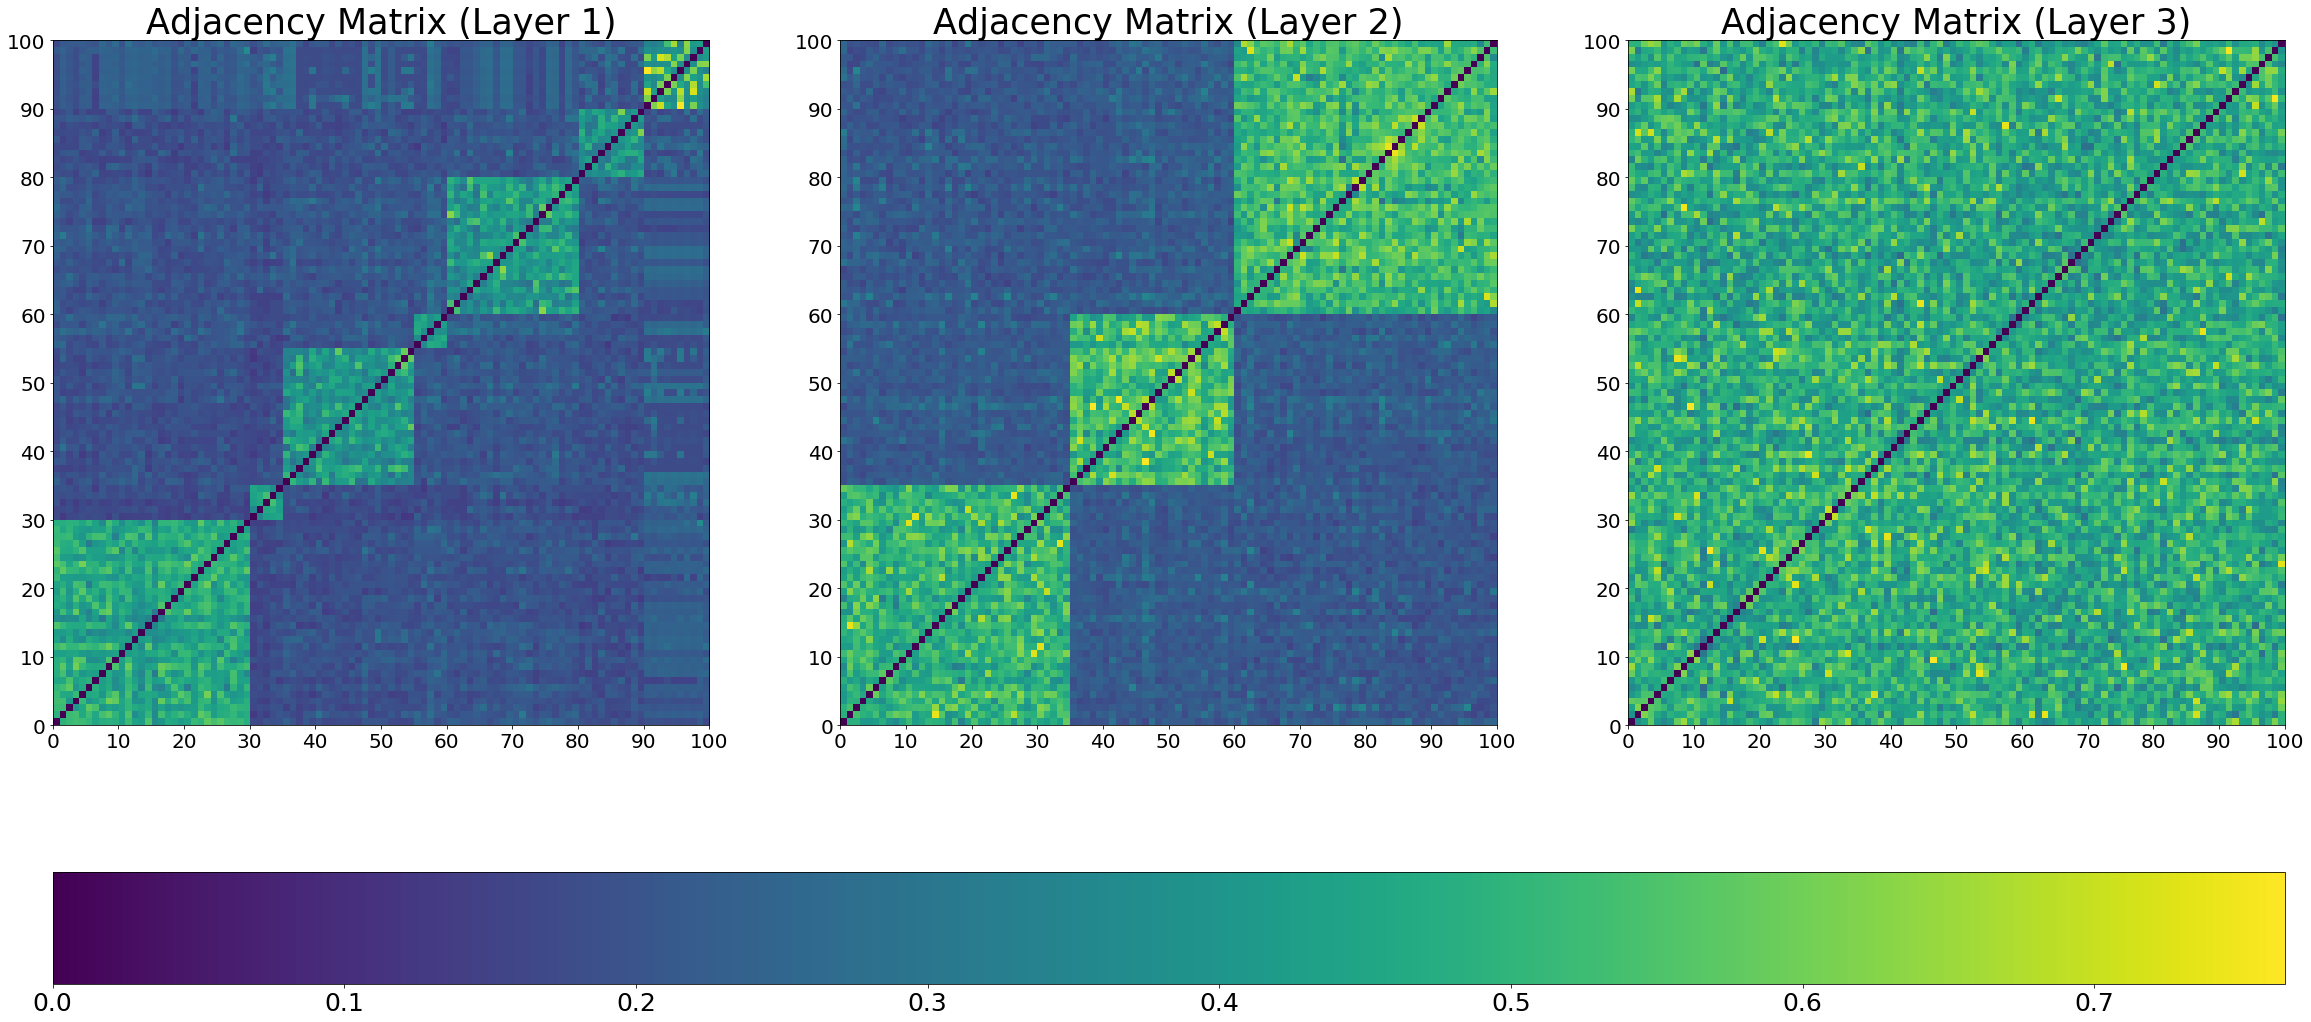

In [12]:
fig,ax = plt.subplots(1,layers, figsize = (40,18))
for i in range(layers):
    k = ax[i].imshow(adjacency_matrices[i], 
                            origin = 'lower', 
                            interpolation='nearest', 
                            aspect='auto',  
                            extent = [0,100,0,100])
    ax[i].set_title('Adjacency Matrix (Layer %d)'%(i +1), fontsize = 35)
    ax[i].set_xticks([k*10 for k in range(11)])
    ax[i].set_yticks([k*10 for k in range(11)])
    ax[i].tick_params(axis = 'both', labelsize = 20)
cbar = fig.colorbar(k, ax = ax.flat, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 25) 
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/adjacency_merge.pdf')

In [13]:
TN = temporal_network(num_neurons, layers, window_size, data = 'list__adjacency', list_adjacency = adjacency_matrices, omega = 1, kind= 'ordinal')

In [14]:
grid = 40
resolutions = np.linspace(0, 1.5, grid)
interlayers = np.linspace(0, 1.5, grid)

In [ ]:
community_sizes = {}
membership_partitions = {}
partitions = {}
parameter_plane = np.zeros((len(resolutions),len(interlayers)))
for i,e in enumerate(interlayers):
    comm_size = []
    membership = []
    partition = []
    igraphs = TN.create_igraph()
    for j,f in enumerate(resolutions):
        parts, inter_parts = TN.leiden(igraphs,e,f)
        c_size_layers, c_size  = TN.membership(inter_parts)
        comm_size.append(c_size)
        membership.append(c_size_layers)
        partition.append(inter_parts)
        parameter_plane[i][j] = c_size
    community_sizes['interlayer %.2f'%e] = comm_size
    membership_partitions['interlayer %.2f'%e] = membership
    partitions['interlayer %.2f'%e] = partition
print('asd')

In [ ]:
index = 8
rasters = {}
fig,ax = plt.subplots(index,index, figsize = (index*10+5,index*10))
for i in range(index):
    for j in range(index):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i]][j], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(13)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i],resolutions[j]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities1_merge.pdf')
print('comm1')

In [ ]:
fig,ax = plt.subplots(index,index, figsize = (index*10+5,index*10))
for i in range(index):
    for j in range(index):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+index]][j], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(13)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+index],resolutions[j]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities2_merge.pdf')

In [ ]:
fig,ax = plt.subplots(index,index, figsize = (index*10+5,index*10))
for i in range(index):
    for j in range(index):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+2*index]][j], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(13)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+2*index],resolutions[j]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities3_merge.pdf')

In [ ]:
fig,ax = plt.subplots(index,index, figsize = (index*10+5,index*10))
for i in range(index):
    for j in range(index):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+3*index]][j], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(13)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+3*index],resolutions[j]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities4_merge.pdf')

In [ ]:
fig,ax = plt.subplots(index,index, figsize = (index*10+5,index*10))
for i in range(index):
    for j in range(index):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+4*index]][j], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(13)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+4*index],resolutions[j]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities5_merge.pdf')

In [ ]:
fig,ax = plt.subplots(index, index, figsize = (index*10+5,index*10))
for i in range(index):
    for j in range(index):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i]][j+index], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(13)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i],resolutions[j+index]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities6_merge.pdf')

In [ ]:
fig,ax = plt.subplots(index,index, figsize = (index*10+5,index*10))
for i in range(index):
    for j in range(index):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+index]][j+index], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(13)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+index],resolutions[j+index]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities7_merge.pdf')

In [ ]:
fig,ax = plt.subplots(index,index, figsize = (index*10+5,index*10))
for i in range(index):
    for j in range(index):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+index]][j+index], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(13)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+2*index],resolutions[j+index]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities8_merge.pdf')

In [ ]:
fig,ax = plt.subplots(index,index, figsize = (index*10+5,index*10))
for i in range(index):
    for j in range(index):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+3*index]][j+index], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(13)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+3*index],resolutions[j+index]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities9_merge.pdf')

In [ ]:
fig,ax = plt.subplots(index,index, figsize = (index*10+5,index*10))
for i in range(index):
    for j in range(index):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+4*index]][j+index], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(13)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+4*index],resolutions[j+index]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities10_merge.pdf')

In [ ]:
fig,ax = plt.subplots(index,index, figsize = (index*10+5,index*10))
for i in range(index):
    for j in range(index):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i]][j+2*index], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(13)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i],resolutions[j+2*index]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities11_merge.pdf')

In [ ]:
fig,ax = plt.subplots(index,index, figsize = (index*10+5,index*10))
for i in range(index):
    for j in range(index):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+index]][j+2*index], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(13)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+index],resolutions[j+index]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities12_merge.pdf')

In [ ]:
fig,ax = plt.subplots(index,index, figsize = (index*10+5,index*10))
for i in range(index):
    for j in range(index):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+2*index]][j+2*index], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(13)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+2*index],resolutions[j+2*index]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities13_merge.pdf')

In [ ]:
fig,ax = plt.subplots(index,index, figsize = (index*10+5,index*10))
for i in range(index):
    for j in range(index):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+3*index]][j+2*index], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(13)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+3*index],resolutions[j+2*index]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities14_merge.pdf')

In [ ]:
fig,ax = plt.subplots(index,index, figsize = (index*10+5,index*10))
for i in range(index):
    for j in range(index):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+4*index]][j+2*index], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(13)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+4*index],resolutions[j+2*index]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities15_merge.pdf')

In [ ]:
fig,ax = plt.subplots(index,index, figsize = (10*index+5,index*10))
for i in range(index):
    for j in range(index):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i]][j+3*index], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(13)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i],resolutions[j+3*index]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities16_merge.pdf')

In [ ]:
fig,ax = plt.subplots(index,index, figsize = (index*10+5,index*10))
for i in range(index):
    for j in range(index):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+index]][j+3*index], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(13)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+index],resolutions[j+3*index]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities17_merge.pdf')

In [ ]:
fig,ax = plt.subplots(index,index, figsize = (index*10+5,index*10))
for i in range(index):
    for j in range(index):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+2*index]][j+3*index], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(13)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+2*index],resolutions[j+3*index]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities18_merge.pdf')

In [ ]:
fig,ax = plt.subplots(index,index, figsize = (index*10+5,index*10))
for i in range(index):
    for j in range(index):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+3*index]][j+3*index], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(13)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+3*index],resolutions[j+3*index]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities19_merge.pdf')

In [ ]:
fig,ax = plt.subplots(index,index, figsize = (index*10+5,index*10))
for i in range(index):
    for j in range(index):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+4*index]][j+3*index], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(13)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+4*index],resolutions[j+3*index]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities20_merge.pdf')

In [ ]:
fig,ax = plt.subplots(index,index, figsize = (index*10+5,index*10))
for i in range(index):
    for j in range(index):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i]][j+4*index], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(13)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i],resolutions[j+4*index]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities21_merge.pdf')

In [ ]:
fig,ax = plt.subplots(index,index, figsize = (index*10+5,index*10))
for i in range(index):
    for j in range(index):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+index]][j+4*index], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(13)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+index],resolutions[j+4*index]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities22_merge.pdf')

In [ ]:
fig,ax = plt.subplots(index,index, figsize = (index*10+5,index*10))
for i in range(index):
    for j in range(index):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+2*index]][j+4*index], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(13)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+2*index],resolutions[j+4*index]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities23_merge.pdf')

In [ ]:
fig,ax = plt.subplots(index,index, figsize = (index*10+5,index*10))
for i in range(index):
    for j in range(index):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+3*index]][j+4*index], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(13)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+3*index],resolutions[j+4*index]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities24_merge.pdf')

In [ ]:
fig,ax = plt.subplots(index,index, figsize = (10*index+5,10*index))
for i in range(index):
    for j in range(index):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+4*index]][j+4*index], ax[i][j])
        ax[i][j].set_xticks([i for i in range(layers)])
        ax[i][j].set_yticks([i*10 for i in range(13)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+4*index],resolutions[j+4*index]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities25_merge.pdf')

In [ ]:
np.savetxt('/projects/academic/smuldoon/bengieru/leiden/results/parameter_plane_merge.txt', parameter_plane, fmt='%f')